In [2]:
import pickle
from scipy import sparse
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import spektral
import os
import tensorflow as tf
import pandas
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import keras_tuner as kt
from scipy.optimize import curve_fit
from scipy.interpolate import make_interp_spline, BSpline
import pandas as pd
import openpyxl

In [12]:
counter = pd.read_excel(r"C:\Users\buing\Documents\CBE 424\heat exchanger\cocurrent.xlsx")
dat = pd.DataFrame(counter)
hot_rate = dat["Ms (kg/s)"]
cold_rate = dat["Mi1 (kg/s)"]
wc = cold_rate
wh = hot_rate
Th_in = dat["Th_in"]
Th_out = dat["Th_out"]
Tc_in = dat["Tc_in"]
Tc_out = dat["Tc_out"]


In [76]:
dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
Cp = 4.182 #J/kgC
Qc = wc*Cp*(Tc_out- Tc_in)      #Qc = wc*Cp_c*(Tc_out - Tc_in)
Qh = wh*Cp*(Th_out- Th_in)   #Qh = wh*Cp_h*(Th_out- Th_in)
Q = (abs(Qc) + abs(Qh))/2
A = 31*np.pi*7.875*0.21/(39.37*39.37)
U = Q/(A*dT_co)
Gi = wc/(np.pi*31*np.power((0.21/39.37),2)/4)
Gs = wh/((np.pi*np.power((2.025/39.37),2)/4)-(np.pi*31*np.power((0.25/39.37),2)/4))
#dT_co = ((Th_in - Tc_in) - (Th_out - Tc_out))/np.log(((Th_in - Tc_in)/(Th_out - Tc_out)))
flip_U = 1/U
#print(U,Gi,Gs,wh)
print(Gi,Gs,Qh,U)

0       22.570935
1       96.685355
2      202.139250
3      305.699159
4      504.175479
5      882.826423
6       30.254657
7      109.202420
8      176.532388
9      356.281632
10     589.449651
11     882.826423
12      28.079599
13     104.814343
14     300.805670
15     621.937354
16     846.976197
17    1144.318093
18      24.540849
19     116.402302
20     267.382187
21     467.376685
22     790.497826
23    1139.742995
24      24.540849
25      58.775327
26     253.759242
27     433.217735
28     732.435547
29    1140.800789
30      65.304781
31     220.110121
32     406.870223
33     651.109980
34     857.882307
35    1140.800789
Name: Mi1 (kg/s), dtype: float64 0     727.179808
1     727.179808
2     727.179808
3     727.179808
4     727.179808
5     727.179808
6     663.360566
7     663.360566
8     663.360566
9     663.360566
10    663.360566
11    663.360566
12    606.430831
13    606.430831
14    606.430831
15    606.430831
16    606.430831
17    606.430831
18    547.586

In [77]:
def func(G,a,b,c,d,e):
    Gi,Gs = G
    return 1/((a/np.power(Gi,b)) + c + (d/np.power(Gs,e)))

In [121]:
guess = [1, 0.3, 0.1, 1,0.7]
a,b,c,d,e = guess
LHS = func((Gi,Gs),a,b,c,d,e)
param = curve_fit(func,(Gi,Gs),U,guess,maxfev=20000)
#param = curve_fit(func,(Gi,Gs),flip_U,guess,bounds=(0.1, [30, 3, 10,30,10]))
LHS_fit = func((Gi,Gs),*param[0])
U_fit = 1/LHS_fit

print(param)

(array([ 2.67733731e+00,  3.14496794e-01, -1.64543756e+01,  1.66448045e+01,
        2.61947505e-03]), array([[ 4.76021145e-02,  6.40436345e-03,  1.78283370e+02,
        -1.78251817e+02,  2.85125125e-02],
       [ 6.40436345e-03,  9.15697963e-04,  3.47494643e+01,
        -3.47436922e+01,  5.55741184e-03],
       [ 1.78283402e+02,  3.47494686e+01,  5.91416267e+07,
        -5.91336134e+07,  9.46059687e+03],
       [-1.78251849e+02, -3.47436965e+01, -5.91336134e+07,
         5.91256013e+07, -9.45931502e+03],
       [ 2.85125176e-02,  5.55741253e-03,  9.46059687e+03,
        -9.45931502e+03,  1.51336556e+00]]))


In [122]:
# = param[0][0]
h_exp = 1/param[0][0]*(np.power(Gi,param[0][1]))
#
k = 0.000598 # W/mK
Di = 0.21/39.37
miu_i = np.power(1/10,3)
h_i = 0.023*k/(Di)*np.power((Di*Gi/miu_i),0.8)*np.power((Cp*miu_i/k),1/3)
print(h_i,h_exp,Di*Gi/miu_i,Cp*miu_i/k)

0     0.227729
1     0.729235
2     1.315527
3     1.831532
4     2.733031
5     4.278381
6     0.287881
7     0.803831
8     1.180426
9     2.070208
10    3.096967
11    4.278381
12    0.271201
13    0.777886
14    1.808040
15    3.232783
16    4.138816
17    5.265221
18    0.243495
19    0.845957
20    1.645452
21    2.572248
22    3.916514
23    5.248374
24    0.243495
25    0.489706
26    1.578035
27    2.420718
28    3.684637
29    5.252270
30    0.532764
31    1.408287
32    2.302205
33    3.353534
34    4.181397
35    5.252270
Name: Mi1 (kg/s), dtype: float64 0     0.995369
1     1.572847
2     1.983429
3     2.258988
4     2.643931
5     3.153300
6     1.091444
7     1.634235
8     1.900711
9     2.370433
10    2.777113
11    3.153300
12    1.066133
13    1.613291
14    2.247553
15    2.824368
16    3.112455
17    3.421370
18    1.021910
19    1.667382
20    2.165820
21    2.581658
22    3.045632
23    3.417062
24    1.021910
25    1.344941
26    2.130492
27    2.520766
28    2

In [123]:
dat_plot = [Gi,flip_U,h_exp]
dat_plot_in = pd.DataFrame({'col1': Gi,
                            'col2':flip_U,
                           'col3': h_exp,
                           'col4': h_i}
                          )
dat_plot_sort = dat_plot_in.sort_values(by = "col1",ascending= True)
print(dat_plot_in.sort_values(by = "col1",ascending= True))

           col1      col2      col3      col4
0     22.570935  0.984758  0.995369  0.227729
24    24.540849  0.853738  1.021910  0.243495
18    24.540849  0.939626  1.021910  0.243495
12    28.079599  0.869579  1.066133  0.271201
6     30.254657  0.917238  1.091444  0.287881
25    58.775327  0.639427  1.344941  0.489706
30    65.304781  0.670176  1.390245  0.532764
1     96.685355  0.506976  1.572847  0.729235
13   104.814343  0.516284  1.613291  0.777886
7    109.202420  0.530160  1.634235  0.803831
19   116.402302  0.509808  1.667382  0.845957
8    176.532388  0.444827  1.900711  1.180426
2    202.139250  0.386729  1.983429  1.315527
31   220.110121  0.447811  2.037275  1.408287
26   253.759242  0.378764  2.130492  1.578035
20   267.382187  0.382800  2.165820  1.645452
14   300.805670  0.355183  2.247553  1.808040
3    305.699159  0.333880  2.258988  1.831532
9    356.281632  0.339992  2.370433  2.070208
32   406.870223  0.343013  2.471510  2.302205
27   433.217735  0.311468  2.52076

Text(114.43180933573598, 0.5265220991056448, '$h_{S-T Corr}$')

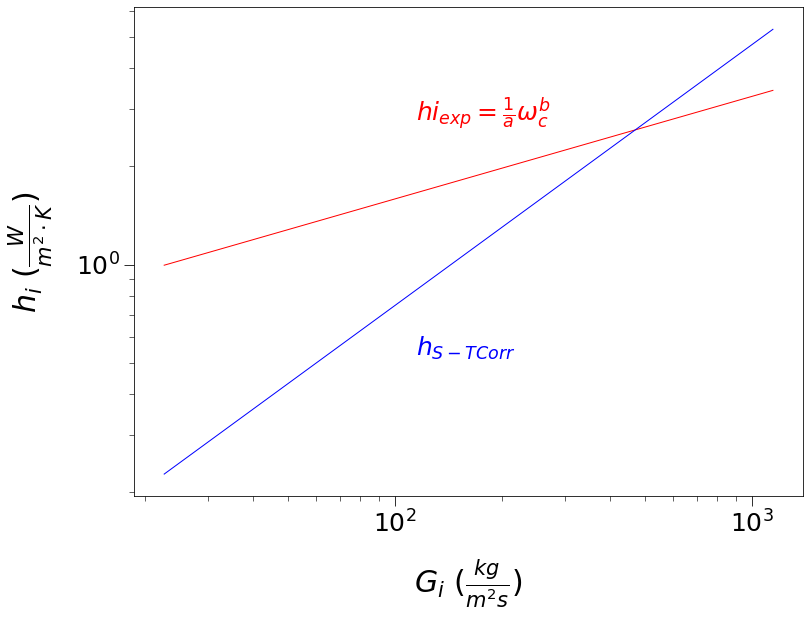

In [125]:
figure(figsize = (12,9))
l_width = 1
Gi_plot,flip_U_plot,h_exp_plot,h_i_plot = dat_plot_sort["col1"],dat_plot_sort["col2"],dat_plot_sort["col3"],dat_plot_sort["col4"]
plt.loglog(Gi_plot,h_exp_plot,'r-',linewidth = l_width, label = "hi_exp")
plt.loglog(Gi_plot,h_i_plot,'b-',linewidth = l_width, label = "hi_i_ST")
plt.ylabel(r"$h_{i}$ $(\frac{W} {m^{2} \cdot{K}})$", fontsize = 30,labelpad=20)
plt.xlabel(r"$G_i$ $(\frac{kg} {m^{2}s})$",fontsize = 30,labelpad=20)
plt.tick_params(axis='both', which='major', labelsize=25, length = 10)
plt.tick_params(axis='both', which='minor', length = 5)
plt.annotate(r"$hi_{exp} =  \frac{1} {a} \omega_c^b$",
             xy = (   Gi_plot.to_numpy()[-1],h_exp_plot.to_numpy()[-1]),
             xytext= (   0.1*(Gi_plot.to_numpy()[-1]),(0.8*h_exp_plot.to_numpy()[-1])),
             color = 'r',fontsize = 25)

plt.annotate("$h_{S-T Corr}$",
             xy = (   Gi_plot.to_numpy()[-1],h_i_plot.to_numpy()[-1]),
             xytext= (   0.1*Gi_plot.to_numpy()[-1],0.1*(h_i_plot.to_numpy()[-1])),
             color = 'b',fontsize = 25)

In [117]:
Gi_plot.to_numpy()[-1]
h_exp_plot.to_numpy()[-1]

7.106566611169592e+44